In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from PIL import Image
import os 
import numpy as np
from tqdm import tqdm_notebook
import csv
import zipfile
import tarfile
!pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import misc, ndimage

In [2]:
# DNN (Flase) or CNN (True)
model_switch = True

In [3]:
def absSobelThresh(img, orient, thresh, sobelKernel = 19):
    
    threshMin=thresh[0]
    threshMax=thresh[1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobelOp = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobelKernel)
    else:
        sobelOp = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobelKernel)
    absSobel = np.absolute(sobelOp)
    scaledSobel = np.uint8(255*absSobel/np.max(absSobel))
    sxbinary = np.zeros_like(scaledSobel)
    sxbinary[(scaledSobel > threshMin) & (scaledSobel < threshMax)] = 1
    binaryOutput = sxbinary 
    
    return binaryOutput

def combinedThreshBinaryImg(img, threshX, threshY, threshColorS, threshColorU, threshColorR):

    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float)
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV).astype(np.float)
    L = hls[:,:,1]
    S = hls[:,:,2]
    R = rgb[:,:,0]
    U = yuv[:,:,1]
    sobelX = absSobelThresh(img, orient='x', thresh=(threshX[0], threshX[1]))
    sobelY = absSobelThresh(img, orient='y', thresh=(threshY[0], threshY[1]))
    sBinary = np.zeros_like(S)
    sBinary[(S >= threshColorS[0]) & (S <= threshColorS[1])] = 1
    rBinary = np.zeros_like(R)
    rBinary[(R >= threshColorR[0]) & (R <= threshColorR[1])] = 1
    uBinary = np.zeros_like(U)
    uBinary[(U >= threshColorU[0]) & (U <= threshColorU[1])] = 1    
    colorBinary = np.dstack(( rBinary, ((sobelX == 1) & (sobelY == 1)), uBinary ))
    combinedBinary = np.zeros_like(sBinary)
    combinedBinary[(rBinary == 1) | (uBinary == 1) | ((sobelX == 1) & (sobelY == 1))] = 1
    
    return combinedBinary

In [4]:
def load_images(path, size, kernel, method):
    images = []
    left = []
    right = []
    gtFile = open('/home/pk2573/train_wheel_speeds.csv') 
    gtReader = csv.reader(gtFile, delimiter = ',')
    next(gtReader, None)
    for row in gtReader:
        if row[0] != "0" and (row[1] != "0" and row[2] != "0"):
            image = Image.open(path +"/train_img_" + row[0] + ".jpg")
            image = image.resize(size, Image.ANTIALIAS)
            
            if method == 1:
                image = np.array(image)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float)
                image = np.array(image).astype("uint8")
                image = combinedThreshBinaryImg(image, 
                                                threshX=(1, 255), 
                                                threshY=(50, 255), 
                                                threshColorS=(1,255), 
                                                threshColorU=(250,250), 
                                                threshColorR=(230,255))
                
            elif method == 2:
                image = np.array(image)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)
                image[:,:,0] = scipy.ndimage.convolve(image[:,:,0], kernel, mode = "constant")
                image = np.array(image).astype("uint8")
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                
            elif method == 3:
                image = np.array(image.convert("L"))
                n_pixels = image.shape[0] + image.shape[1]
                image = cv2.Canny(image,20,20) 
                image = cv2.dilate(image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2)))
                
            elif method == 4:                
                image = np.array(image)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float)
                image[:,:,0] = scipy.ndimage.convolve(image[:,:,0], kernel, mode = "constant")
                image = np.array(image).astype("uint8")
                hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)
                yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV).astype(np.float)
                hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float)
                rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float)
                L = hls[:,:,1]
                S = hls[:,:,2]
                R = rgb[:,:,0]
                H = hls[:,:,0]
                threshX = (1, 255) 
                threshY = (1, 255) 
                threshColorS = (200, 255)
                threshColorL = (200, 255)
                threshColorR = (200, 255)

                sBinary = np.zeros_like(L)
                sBinary[(S >= threshColorS[0]) & (S <= threshColorS[1])] = 1
                lBinary = np.zeros_like(L)
                lBinary[(L >= threshColorL[0]) & (L <= threshColorL[1])] = 1
                rBinary = np.zeros_like(R)
                rBinary[(R >= threshColorR[0]) & (R <= threshColorR[1])] = 1

                afterProcess = np.dstack((sBinary, lBinary, rBinary))
                image = np.array(afterProcess).astype("uint8")
                
            image = image / np.max(image)
            images.append(image[50:])
            left.append(row[1]) 
            right.append(row[2])
    
    return np.array(images), np.array(left).astype("uint8"), np.array(right).astype("uint8")

In [5]:
def un_zip(path):
    path, fname = os.path.split(path)
    if (fname.endswith("tar.gz")):
        tar = tarfile.open(fname, "r")
        tar.extractall(path)
        tar.close()
    elif (fname.endswith("tar.gz")):
        tar = tarfile.open(fname, "r:")
        tar.extractall(path)
        tar.close()
    elif (fname.endswith("zip")):
        zip_ref = zipfile.ZipFile(fname, 'r')
        zip_ref.extractall(path)
        zip_ref.close() 
            
    return 

In [6]:
path = "/home/pk2573/gopigo_training.tar.gz"
un_zip(path)

In [7]:
new_path = "/home/pk2573/training_images"

In [8]:
kernel = np.array([[-1, -1, -1], 
                             [-1, 8, -1],
                             [-1, -1, -1]])

In [9]:
size = 128,128
method = 1
images, left, right = load_images(new_path, size, kernel, method)

print("Images:", len(images), ", Shape:", images.shape)
print("Left:", len(left), ", Shape:", left.shape)
print("Right:", len(right), ", Shape:", right.shape)

Images: 1045 , Shape: (1045, 78, 128)
Left: 1045 , Shape: (1045,)
Right: 1045 , Shape: (1045,)


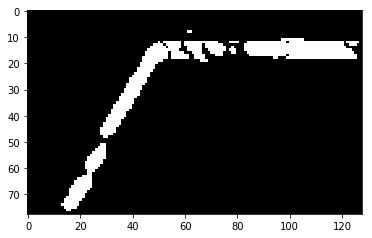

In [10]:
plt.imshow(images[1], cmap = "gray")

In [11]:
if len(images.shape) == 3:
    images = np.reshape(images, (images.shape[0], images.shape[1], images.shape[2], 1))
print(images.shape)

(1045, 78, 128, 1)


In [12]:
class CNN(object):
    
    def __init__(self, activation, x_train, y_train, epochs, batch_size, input_shape, val_split, padding, filter_size, pooling_size):
        self.activation = activation
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.val_split = val_split
        self.padding = padding
        self.filter = filter_size
        self.pooling = pooling_size
        
        pass 
    
    def create_model(self):

        img = Input(shape = self.input_shape, name = 'images')

        x = tf.keras.layers.Conv2D(512, self.filter, padding = self.padding, activation = self.activation)(img)
        x = tf.keras.layers.MaxPooling2D(self.pooling)(x)
        x = tf.keras.layers.Conv2D(256, self.filter, padding = self.padding, activation = self.activation)(x)
        x = tf.keras.layers.MaxPooling2D(self.pooling)(x)
        x = tf.keras.layers.Conv2D(128, self.filter, padding = self.padding, activation = self.activation)(x)
        x = tf.keras.layers.MaxPooling2D(self.pooling)(x)
        x = tf.keras.layers.Conv2D(64, self.filter, padding = self.padding, activation = self.activation)(x)
        x = tf.keras.layers.GlobalMaxPooling2D()(x)
        x = tf.keras.layers.Dense(128, activation = self.activation)(x)
        x = tf.keras.layers.Dense(64, activation = self.activation)(x)

        left_pred = tf.keras.layers.Dense(1, name = "left")(x)
        right_pred = tf.keras.layers.Dense(1, name = "right")(x)
        model = Model(img, [left_pred, right_pred])
        
        return model
    
    def run_model(self):
        model = self.create_model()
        model.compile("adam", loss = {'left': 'mse', 'right': 'mse'})
        model.summary()
        
        history = model.fit(self.x_train, {'left': self.y_train[0], 'right': self.y_train[1]}, 
                            epochs = self.epochs, 
                            batch_size = self.batch_size, 
                            validation_split = self.val_split,
                            verbose = 0)
        
        return history, model

In [13]:
class DNN(object):
    
    def __init__(self, activation, x_train, y_train, epochs, batch_size, input_shape, val_split):
        self.activation = activation
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.val_split = val_split
        
        pass 
    
    def create_model(self):

        img = Input(shape = self.input_shape, name = 'images')
    
        x = tf.keras.layers.Flatten()(img)
        x = tf.keras.layers.Dense(1024, activation = self.activation)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(512, activation = self.activation)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(256, activation = self.activation)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(128, activation = self.activation)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(64, activation = self.activation)(x)

        left_pred = tf.keras.layers.Dense(1, name = "left")(x)
        right_pred = tf.keras.layers.Dense(1, name = "right")(x)
        model = Model(img, [left_pred, right_pred])
        
        return model
    
    def run_model(self):
        model = self.create_model()
        model.compile("adam", loss = {'left': 'mse', 'right': 'mse'})
        model.summary()
        
        history = model.fit(self.x_train, {'left': self.y_train[0], 'right': self.y_train[1]}, 
                            epochs = self.epochs, 
                            batch_size = self.batch_size, 
                            validation_split = self.val_split,
                            verbose = 0)
        
        return history, model

In [14]:
mask =  np.random.rand(images.shape[0]) < 0.80
x_train, x_test = images[mask,:,:,:], images[~mask,:,:,:]
train_left, test_left, train_right, test_right = left[mask], left[~mask], right[mask], right[~mask]
y_train = [train_left, train_right]
y_test = [test_left, test_right]

print(x_train.shape)

(840, 78, 128, 1)


In [15]:
activation = "relu"
epochs = 100
batch_size = 16
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) 
val_split = 0.2
padding = "same"
filter_size = (3,3)
pool_size = (2,2)

if model_switch:
    model = CNN(activation, x_train, y_train, epochs, batch_size, input_shape, val_split, padding, filter_size, pool_size)
    history, model = model.run_model()
else:
    model = DNN(activation, x_train, y_train, epochs, batch_size, input_shape, val_split)
    history, model = model.run_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 78, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 128, 512) 5120        images[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 39, 64, 512)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 39, 64, 256)  1179904     max_pooling2d[0][0]              
__________________________________________________________________________________________________
max_poolin

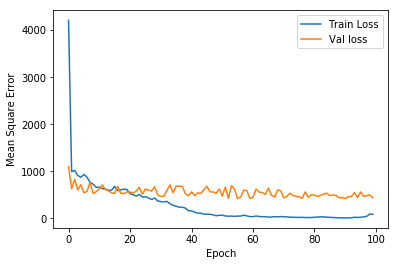

In [16]:
plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend()

In [17]:
pred = np.array(model.predict(x_test))
left_pred = pred[0,:,0]
right_pred = pred[1,:,0]
print(np.max(left_pred - y_test[0]))
print(np.max(right_pred - y_test[1]))

59.051064
107.17828


<function matplotlib.pyplot.show(*args, **kw)>

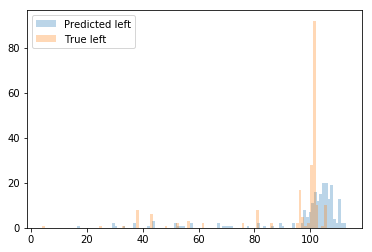

In [18]:
n_bins = 100
plt.hist(left_pred, bins = n_bins, alpha = 0.3, label = "Predicted left")
plt.hist(y_test[0], bins = n_bins, alpha = 0.3, label = "True left")
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

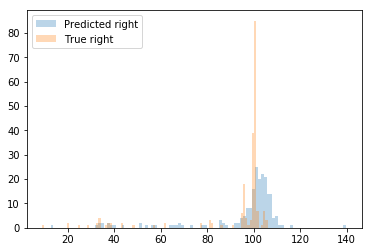

In [19]:
n_bins = 100
plt.hist(right_pred, bins = n_bins, alpha = 0.3, label = "Predicted right")
plt.hist(y_test[1], bins = n_bins, alpha = 0.3, label = "True right")
plt.legend()
plt.show

In [21]:
a = pd.DataFrame(data = [left_pred, y_test[0], left_pred - y_test[0], right_pred, y_test[1], right_pred - y_test[1], left_pred / right_pred, y_test[0] / y_test[1]]).T
a.columns = ["Pred_Left", "True_Left", "Diff", "Pred_Right", "True_Right", "Diff", "Pred_Ratio", "True_Ratio"]
a.iloc[:20]

,Pred_Left,True_Left,Diff,Pred_Right,True_Right,Diff,Pred_Ratio,True_Ratio
0,104.781479,98.0,6.781479,56.476154,25.0,31.476154,1.855322,3.920000
1,102.157310,100.0,2.157310,51.717724,43.0,8.717724,1.975286,2.325581
2,107.951591,101.0,6.951591,106.786652,96.0,10.786652,1.010909,1.052083
3,105.643181,96.0,9.643181,104.190018,101.0,3.190018,1.013947,0.950495
4,104.557594,101.0,3.557594,92.411835,100.0,-7.588165,1.131431,1.010000
5,105.271675,101.0,4.271675,104.276802,101.0,3.276802,1.009541,1.000000
6,103.713097,101.0,2.713097,102.969826,101.0,1.969826,1.007218,1.000000
7,100.775391,101.0,-0.224609,100.912132,96.0,4.912132,0.998645,1.052083
8,101.759247,101.0,0.759247,103.325691,100.0,3.325691,0.984840,1.010000
9,105.522026,100.0,5.522026,101.064499,104.0,-2.935501,1.044106,0.961538
